In [103]:
import numpy as np
import pandas as pd
import json
import os
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from transformers import BertTokenizer, BertTokenizerFast, BertForSequenceClassification, AdamW
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/tobysavage/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tobysavage/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
directory = '../../data/BERT'

for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        print(filename)


ambig_dev_BERT_full.csv
ambig_train_BERT.csv
ambig_test_BERT.csv
ambig_dev_BERT.csv


In [3]:
df_train = pd.read_csv('../../data/BERT/ambig_train_BERT.csv')
df_train.head()

,ambiguous_question,ambig_class
0,Which country is opposite to india on globe?,0
1,When was the book of common prayer first publi...,0
2,When did the first power rangers movie come out?,0
3,Who is the netflix movie roxanne roxanne about?,0
4,Who plays blake in bring it on worldwide showd...,0


In [4]:
df_dev = pd.read_csv('../../data/BERT/ambig_dev_BERT.csv')
df_dev.head()

,ambiguous_question,ambig_class
0,Who plays the doctor in dexter season 1?,0
1,How often does spermatogeneis—the production o...,0
2,How often does spermatogeneis—the production o...,0
3,When was the first remote control tv invented?,0
4,When was the first remote control tv invented?,0


In [5]:
df_test = pd.read_csv('../../data/BERT/ambig_test_BERT.csv')
df_test.head()

,ambiguous_question,ambig_class
0,Who is the guy in the don't leave music video?,1
1,Who wrote the song pass me not o gentle savior?,0
2,What was shaggys real name in scooby doo?,0
3,Where is the world cup going to be held at?,1
4,How many rick and morty episodes are out in se...,1


In [6]:
# df_dev_full = pd.read_csv('../../data/BERT/ambig_dev_BERT_full.csv')
# df_dev_full.head()

Model Set Up

In [7]:
# CITATION: HuggingFace on how to fine-tune a model (https://huggingface.co/docs/transformers/training)
# Also used help from previous coursework from NNDL and ADL of this semester.
# Help from ChatGPT on data type/syntax on specific data values
# This goes for the initialization of the tokenizer, model, and training loop.

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.config.dropout = 0.1

# move the model to the GPU
model.to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
inputs_train = list(df_train['ambiguous_question'])
targets_train = list(df_train['ambig_class'])

# Tokenize inputs and targets
inputs_train = tokenizer(inputs_train, padding=True, truncation=True, return_tensors='pt')
targets_train = torch.tensor(targets_train)

In [9]:
print(targets_train.size())

torch.Size([6575])


In [10]:
# CITATION: Class produced by ChatGPT to process specific data into dataloader

# START: COPIED FROM ChatGPT (for help seeting up data for dataloader)

class AmbigNQDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    
    def __len__(self):
        return len(self.labels)
    
dataset_train = AmbigNQDataset(inputs_train, targets_train)
# END: COPIED FROM ChatGPT (for syntax help)


loader_train = DataLoader(dataset_train, batch_size = 10, shuffle=True)

In [11]:
# CITATION: Inspiration from  NNDL and ADL coursework on formatting


inputs_dev = list(df_dev['ambiguous_question'])
targets_dev = list(df_dev['ambig_class'])

inputs_dev = tokenizer(inputs_dev, padding=True, truncation=True, return_tensors='pt')
targets_dev = torch.tensor(targets_dev)
dataset_dev = AmbigNQDataset(inputs_dev, targets_dev)
loader_dev = DataLoader(dataset_dev, batch_size = 10, shuffle = True)

In [12]:
# CITATION: Inspiration from  NNDL and ADL coursework on formatting

inputs_test = list(df_test['ambiguous_question'])
targets_test = list(df_test['ambig_class'])

inputs_test = tokenizer(inputs_test, padding=True, truncation=True, return_tensors='pt')
targets_test = torch.tensor(targets_test)
dataset_test = AmbigNQDataset(inputs_test, targets_test)
loader_test = DataLoader(dataset_test, batch_size = 10, shuffle = False)

In [13]:
# inputs_dev_full = list(df_dev_full['ambiguous_question'])
# targets_dev_full = list(df_dev_full['ambig_class'])

# # Tokenize inputs and targets
# inputs_dev_full = tokenizer(inputs_dev_full, padding=True, truncation=True, return_tensors='pt')
# targets_dev_full = torch.tensor(targets_dev_full)
# dataset_dev_full = AmbigNQDataset(inputs_dev_full, targets_dev_full)
# loader_dev_full = DataLoader(dataset_dev_full, batch_size = 10, shuffle = True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
# CITATION: HuggingFace on how to fine-tune a model (https://huggingface.co/docs/transformers/training)
# Also used help from previous homework assignments from NNDL and ADL of this semester.
# Help from ChatGPT on data type/syntax on specific data values
# This goes for the initialization of the tokenizer, model, and training loop.

# load pre-trained BERT model for fine-tuning
epochs = 2
# model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Early Stopping Parameters
patience = 1
min_delta = 0.001
best_val_loss = np.inf
patience_counter = 0

training_losses = []
validation_losses = []


# START: REFACTORED FROM https://huggingface.co/docs/transformers/training
# training loop
model.train() # put model in train mode
for epoch in range(epochs):
    total_train_loss = 0
    for batch in loader_train:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        resultings = batch['labels'].to('cuda')
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=resultings)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
# END: REFACTORED FROM  https://huggingface.co/docs/transformers/training
        
        
        total_train_loss +=loss.item()
        
    avg_train_loss = total_train_loss / len(loader_train)
    training_losses.append(avg_train_loss)
    print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}")
    
    
    # Validation Step
# START: REFACTORED FROM https://huggingface.co/docs/transformers/training

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in loader_dev:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
# END: REFACTORED FROM  https://huggingface.co/docs/transformers/training            
            
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss/len(loader_dev)
    validation_losses.append(avg_val_loss)
    print(f"Epoch: {epoch}, Validation Loss: {avg_val_loss}")
    
    if avg_val_loss + min_delta < best_val_loss:
        best_val_loss = avg_val_loss
        # CITATION: Early Stopping with a patients counter implemented suggested from ChatGPT
        patience_counter = 0  # reset counter if improvement is found
    else:
        patience_counter += 1  # increment counter if no improvement

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break
    
    model.train()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0, Training Loss: 0.6720523900808172
Epoch: 0, Validation Loss: 0.6368781262672091
Epoch: 1, Training Loss: 0.6175539037467499
Epoch: 1, Validation Loss: 0.6425497644996069
Stopping early due to no improvement in validation loss.


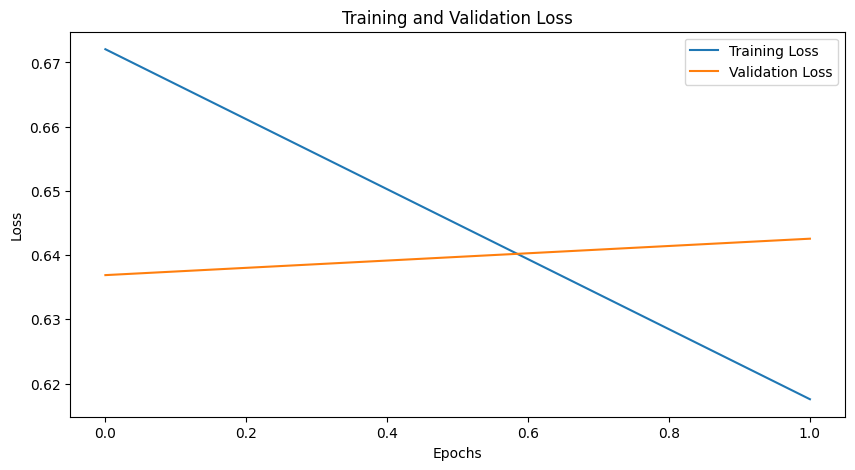

In [16]:
# cpu_training_loss = [loss_item.item() for loss_item in training_losses]

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [60]:
# CITATION: HuggingFace on how to fine-tune a model (https://huggingface.co/docs/transformers/training)
# Also used help from previous homework assignments from NNDL and ADL of this semester.
# Help from ChatGPT on data type/syntax on specific data values
# This goes for the initialization of the tokenizer, model, and training loop.

# Test Step
# START: REFACTORED FROM (https://huggingface.co/docs/transformers/training) & (https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/text_generation)
model.eval()  # put model in evaluation mode
total_test_loss = 0
predictions, true_labels = [], []

with torch.no_grad():
    for batch in loader_test:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
# END: REFACTORED FROM (https://huggingface.co/docs/transformers/training) & (https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/text_generation)

        total_test_loss += loss.item()

        # CITATION: Ran into an issue with missmatch of where data was stored, ChatGPT suggested to use CPU here.
        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu()
        label_ids = labels.to('cpu')
        predicted_labels = torch.argmax(logits, axis=1)

        # Store predictions and true labels
        predictions.append(predicted_labels.numpy())
        true_labels.append(label_ids.numpy())

avg_test_loss = total_test_loss / len(loader_test)
print(f"Test Loss: {avg_test_loss}")


Test Loss: 0.6644858533264237


In [67]:
# Calculate F1 per epoch or something?
# del predictions[-1]
# del true_labels[-1]

# print(len(true_labels))
# print(len(predictions))

F1_result = f1_score(true_labels, predictions, average='micro')
print("F1 Score: ", F1_result)

F1 Score:  0.6467553624762421


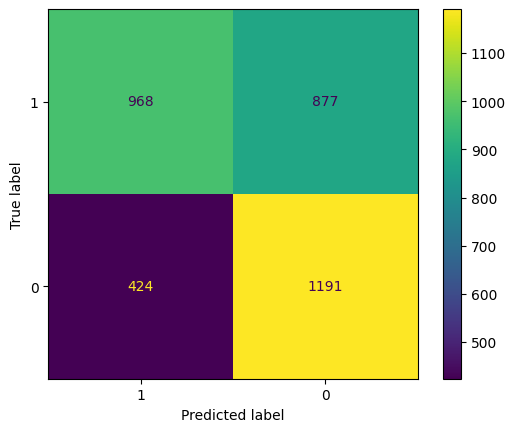

In [97]:
# Flatten the predictions and true_labels
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Compute the confusion matrix
cm = confusion_matrix(flat_true_labels, flat_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [1, 0])

cm_display.plot()
plt.show()

# Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.ylabel('Actual Labels')
# plt.xlabel('Predicted Labels')
# plt.title('Confusion Matrix')
# plt.show()

In [110]:
precision = precision_score(flat_true_labels, flat_predictions, average='micro')
recall = recall_score(flat_true_labels, flat_predictions, average='micro')
accuracy = accuracy_score(flat_true_labels, flat_predictions)

# Manually Calculated Metrics

# precision = 968/1392
# recall = 968/1854
# accuracy = (968+1191)/(968+877+1191+424)
# F1_result = (2*precision*recall)/(precision+recall)

print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {F1_result}")

Precision Score: 0.6239884393063584
Recall Score: 0.6239884393063584
Accuracy Score: 0.6239884393063584
F1 Score: 0.6467553624762421


In [1]:
precision = 968/1392
recall = 968/1854
accuracy = (968+1191)/(968+877+1191+424)
F1_result = (2*precision*recall)/(precision+recall)

print(f"Precision Score: {precision}")
print(f"Recall Score: {recall}")
print(f"Accuracy Score: {accuracy}")
print(f"F1 Score: {F1_result}")

Precision Score: 0.6954022988505747
Recall Score: 0.5221143473570659
Accuracy Score: 0.6239884393063584
F1 Score: 0.5964263709180531


In [111]:
model.save_pretrained('final_pretrained_saves_BERT')
tokenizer.save_pretrained('final_pretrained_saves_BERT')

('final_pretrained_saves_BERT/tokenizer_config.json',
 'final_pretrained_saves_BERT/special_tokens_map.json',
 'final_pretrained_saves_BERT/vocab.txt',
 'final_pretrained_saves_BERT/added_tokens.json')